In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train=pd.read_csv("train.csv")
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


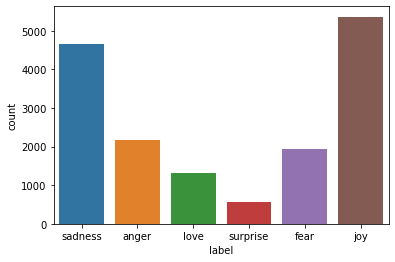

In [3]:
sns.countplot(x='label', data=train)
plt.show()

In [4]:
validation=pd.read_csv("validation.csv")
validation.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


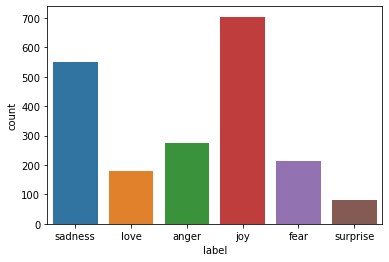

In [5]:
sns.countplot(x='label', data=validation)
plt.show()

In [6]:
test=pd.read_csv("Test.csv")
test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


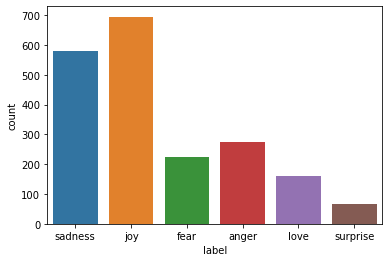

In [7]:
sns.countplot(x='label', data=test)
plt.show()

In [8]:
# Data Preprocessing
def sample_data(df, samples_per_emotion):
    return df.groupby('label').apply(lambda x: x.sample(samples_per_emotion)).reset_index(drop=True)

train_samples_per_emotion = 20
valid_samples_per_emotion = 10
test_samples_per_emotion = 10

train_df = pd.read_csv('train.csv')
train_df = sample_data(train_df, train_samples_per_emotion)
valid_df = pd.read_csv('validation.csv')
valid_df = sample_data(valid_df, valid_samples_per_emotion)
test_df = pd.read_csv('test.csv')
test_df = sample_data(test_df, test_samples_per_emotion)

label_map = {'joy': 0, 'sadness': 1, 'anger': 2, 'love': 3, 'fear': 4, 'surprise': 5}


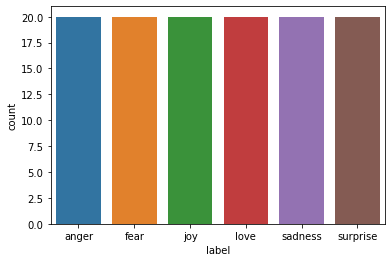

In [9]:
# Plot distribution of labels
sns.countplot(x='label', data=train_df)
plt.show()

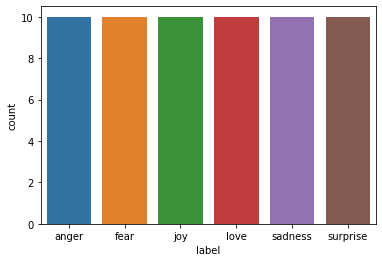

In [10]:
# Plot distribution of labels
sns.countplot(x='label', data=valid_df)
plt.show()

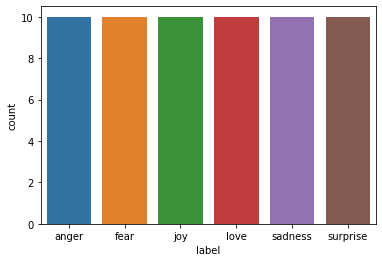

In [11]:
# Plot distribution of labels
sns.countplot(x='label', data=test_df)
plt.show()

In [12]:
#Tokenizing
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['text'].values
        self.labels = [label_map[label] for label in dataframe['label'].values]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            padding='max_length', # Added this line
            truncation=True,
            max_length=MAX_LENGTH, # Added this line
            return_tensors="pt"
        )
        label = torch.tensor(self.labels[idx])
        return inputs, label

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = EmotionDataset(train_df, tokenizer)
valid_dataset = EmotionDataset(valid_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LENGTH = 512

def objective(trial):
    
    lr = trial.suggest_categorical('lr', [2e-5, 2e-3])
    batch_size = trial.suggest_categorical('batch_size', [32]) # You can also hard-code this since there's only one value

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
    model.to(device)

    
    optimizer = AdamW(model.parameters(), lr=lr)

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1):
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}  # Notice the squeeze()
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

        # Validation Loop
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, labels = batch
                inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}  # Notice the squeeze()
                labels = labels.to(device)
                outputs = model(**inputs)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(valid_loader)
        val_acc /= len(valid_loader)
        print(f"Epoch {epoch}: Val Loss: {val_loss}, Val Acc: {val_acc}")

    return val_acc  # Return the validation accuracy as the evaluation metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

best_params = study.best_params


[I 2023-08-13 22:41:20,522] A new study created in memory with name: no-name-7a950377-67b9-497e-a483-2a527cde3f93
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\gokha\anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[I 2023-08-13 22:50:39,717] Trial 0 finished with value: 0.15625 and parameters: {'lr': 0.002, 'batch_size': 32}. Best is trial 0 with value: 0.15625.


Epoch 0: Val Loss: 1.9034769833087921, Val Acc: 0.15625


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-08-13 22:58:54,784] Trial 1 finished with value: 0.15625 and parameters: {'lr': 0.002, 'batch_size': 32}. Best is trial 0 with value: 0.15625.


Epoch 0: Val Loss: 1.9789710342884064, Val Acc: 0.15625


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-08-13 23:07:03,804] Trial 2 finished with value: 0.16666666666666666 and parameters: {'lr': 2e-05, 'batch_size': 32}. Best is trial 2 with value: 0.16666666666666666.


Epoch 0: Val Loss: 1.8280033767223358, Val Acc: 0.16666666666666666


In [14]:
from transformers import AdamW
import torch.optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve best parameters from Optuna
best_params = study.best_params
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Re-create the DataLoaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model.to(device)

# Define the optimizer (AdamW with the best learning rate)
optimizer = AdamW(model.parameters(), lr=best_lr)

# Define the loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Training and Validation Loop
for epoch in range(1):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            val_acc += (preds == labels).sum().item() / len(labels)
    print(f"Validation Loss: {val_loss/len(valid_loader)}")
    print(f"Validation Accuracy: {val_acc/len(valid_loader)}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Loss: 1.807539165019989
Validation Accuracy: 0.15625


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Test Loop
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {key: value.squeeze().to(device) for key, value in inputs.items()}
        labels = labels.to(device)  # Move labels to the same device as the model
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())  # Convert labels back to CPU

# Compute metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")


Test Accuracy: 0.21666666666666667
Test Precision: 0.2402482269503546
Test Recall: 0.21666666666666667
Test F1 Score: 0.12838915470494416


C:\Users\gokha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


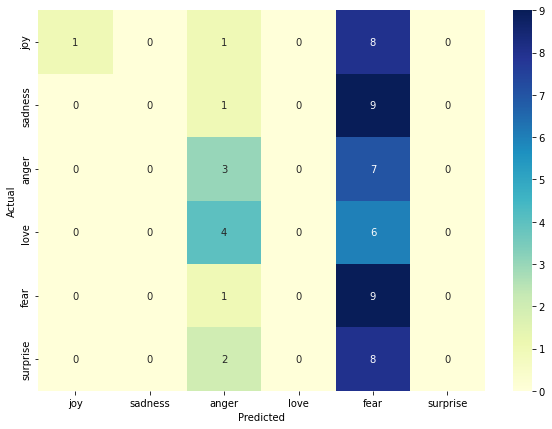

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()